# 2.3-xgboost-toxcast.ipynb

In [49]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Load dataset
toxcast = pd.read_csv("../data/interim/toxcast_ecfp4.csv")

In [29]:
toxcast.head()

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up,ECFP4
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000000000000000000000000000000000000000000000...
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000000000000000000000000000001000000000000...
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0010100000000010000000000000000001000000000000...
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000000000000000000000000000000000000000000000...
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000000000000000000000000000000000000000000000...


In [30]:
# Check the fewest number of records for an assay
min(toxcast.count())

50

Fewest number of observations for an assay is 50, so there shouldn't be an issue where the program fails due to there being too few records.

In [41]:
outcomes['max_depth'][:10].mode()

0    6
Name: max_depth, dtype: object

# Model fitting

In [35]:
# Create list of columns to exclude
exclude_columns = ['smiles', 'ECFP4']

# Get list of assays without excluded_columns
assays = [col for col in toxcast.columns.tolist() if col not in exclude_columns]

# Create empty dataframe
outcomes = pd.DataFrame(columns=['assay', 'auroc', 'max_depth', 'gamma', 'eta'])

# Run model on each assay
for i, assay in enumerate(assays):

    # Filter rows with NAs
    tmp = toxcast[[assay, 'ECFP4']]
    tmp = tmp.dropna()
    
    # Convert each bit of bitstring to feature
    X = tmp["ECFP4"].apply(lambda x: pd.Series(list(x))).astype(int)
    
    # Get outcome
    y = tmp[assay]
    
    # Create 80-20 test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if i < 1:
        print("Identifying optimal model hyperparameters...")
    
    # Conduct hyperparameter search for first 10 assays only
    if i < 10:
    
        # Define the parameters for the XGBoost model
        param_grid = {
            'max_depth': [3, 4, 5, 6, 7, 8],
            'gamma': [0.01, 0.1, 0.5, 1, 2, 5],
            'eta': [0.1, 0.2, 0.4, 0.5]
        }

        # Get ratio of cases to controls
        ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
        remainder = ratio % 5
        ratio -= remainder

        # Create a XGBoost classifier with appropriate weighting to positive cases
        xgb_model = xgb.XGBClassifier(eval_metric='logloss',
                                      scale_pos_weight=ratio
                                     )

        # Setup the random search with 4-fold cross validation
        random_search = RandomizedSearchCV(xgb_model, param_grid, cv=4, n_iter=20, random_state=42)

        # Carry out the random search
        random_search.fit(X_train, y_train)

        # Get the best parameters
        best_params = random_search.best_params_
        print(f"Best parameters for {assay}: {best_params}")

    if i == 10:
        # Calculate the mode
        mode_max_depth = outcomes['max_depth'].mode().values[0]
        mode_gamma = outcomes['gamma'].mode().values[0]
        mode_eta = outcomes['eta'].mode().values[0]

        # Save to a dictionary
        best_params = {'max_depth': mode_max_depth, 'gamma': mode_gamma, 'eta': mode_eta}

        # Output mode hyperparameters
        print(f"Selected model hyperparameters\nmax_depth: {mode_max_depth}\ngamma: {mode_gamma}\neta: {mode_eta}")
        print("Fitting remaining models with selected hyperparameters...")
    
    # Train the XGBoost model with the best parameters
    num_round = 20
    model = xgb.XGBClassifier(**best_params, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    preds_proba = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)

    # Calculate the AUROC score
    auroc = roc_auc_score(y_test, preds_proba)
    
    # Add AUROC and params to dataframe
    new_row = {'assay': assay, 'auroc': auroc, 'max_depth': best_params['max_depth'], 'gamma': best_params['gamma'], 'eta': best_params['eta']}
    new_row = pd.DataFrame([new_row])  # Convert the dictionary to a single-row DataFrame
    outcomes = pd.concat([outcomes, new_row], ignore_index=True)
    
    # Print progress
    print(f"{i+1}/{len(assays)} model(s) fit")
    
# Write csv to data/interim
outcomes.to_csv('../data/interim/toxcast-xgboost-outcomes.csv', index=False)

Identifying optimal model hyperparameters...
Best parameters for ACEA_T47D_80hr_Negative: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
1/617 model(s) fit
Best parameters for ACEA_T47D_80hr_Positive: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
2/617 model(s) fit
Best parameters for APR_HepG2_CellCycleArrest_24h_dn: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
3/617 model(s) fit
Best parameters for APR_HepG2_CellCycleArrest_24h_up: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
4/617 model(s) fit
Best parameters for APR_HepG2_CellCycleArrest_72h_dn: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
5/617 model(s) fit
Best parameters for APR_HepG2_CellLoss_24h_dn: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
6/617 model(s) fit
Best parameters for APR_HepG2_CellLoss_72h_dn: {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}
7/617 model(s) fit
Best parameters for APR_HepG2_MicrotubuleCSK_24h_dn: {'max_depth': 7, 'gamma': 0.1, 'eta': 0.4}
8/617 model(s) fit
Best parameters for APR_HepG2_MicrotubuleCSK_24h_up: {'max_d

# Visualise model performance

In [43]:
performance = pd.read_csv("../data/interim/toxcast-xgboost-outcomes.csv")
performance.head()

,assay,auroc,max_depth,gamma,eta
0,ACEA_T47D_80hr_Negative,0.754067,6,0.1,0.5
1,ACEA_T47D_80hr_Positive,0.643025,6,0.1,0.5
2,APR_HepG2_CellCycleArrest_24h_dn,0.592977,6,0.1,0.5
3,APR_HepG2_CellCycleArrest_24h_up,0.626160,6,0.1,0.5
4,APR_HepG2_CellCycleArrest_72h_dn,0.638365,6,0.1,0.5


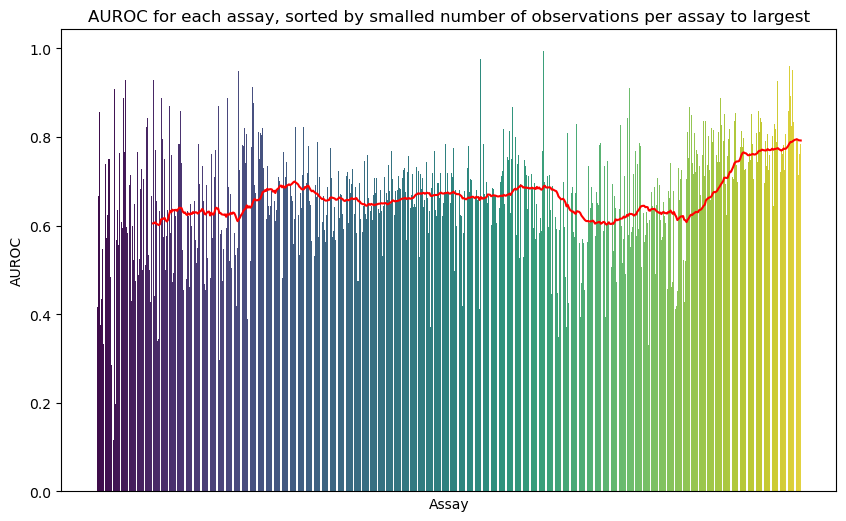

In [57]:
# Count number of observations for each assay
count_dict = toxcast.notnull().sum().to_dict()

# Add counts for each assay to performance df
performance['num_observations'] = performance['assay'].map(count_dict)

# Sorting dataframe by 'datapoints' column
df_sorted = performance.sort_values('num_observations', ascending=True)

# Calculate rolling average of 'auroc' values
df_sorted['rolling_avg'] = df_sorted['auroc'].rolling(window=50).mean()

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(data=df_sorted, x='assay', y='auroc', order=df_sorted['assay'], palette='viridis')
plt.plot(df_sorted['assay'], df_sorted['rolling_avg'], color='red')  # plot the rolling average
plt.title('AUROC for each assay, sorted by smalled number of observations per assay to largest')
plt.xlabel('Assay')
plt.ylabel('AUROC')
plt.xticks([])
plt.show()

Appears to be an increase in model performance as number of observations per assay increases.

# Stability analysis

I want to check how much the AUROC changes for different seeds.

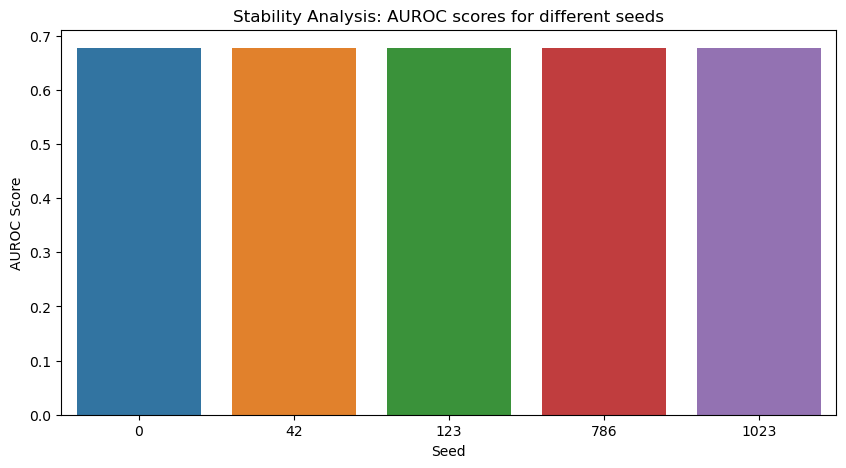

In [55]:
best_params = {'max_depth': 6, 'gamma': 0.1, 'eta': 0.5}

# Initialize the seeds
seeds = [0, 42, 123, 786, 1023]

auroc_scores = []

for i, seed in enumerate(seeds):
    
    # Train the XGBoost model with the best parameters and different seeds
    model = xgb.XGBClassifier(**best_params, random_state=seed, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    preds_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate the AUROC score
    auroc = roc_auc_score(y_test, preds_proba)
    
    # Append auroc score to list for visualization
    auroc_scores.append(auroc)

# Convert seeds and scores to DataFrame
df = pd.DataFrame({'Seeds': seeds, 'AUROC Scores': auroc_scores})

# Plot the AUROC scores for different seeds
plt.figure(figsize=(10, 5))
sns.barplot(x='Seeds', y='AUROC Scores', data=df)
plt.title('Stability Analysis: AUROC scores for different seeds')
plt.xlabel('Seed')
plt.ylabel('AUROC Score')
plt.show()

No apparent difference with different seeds.